# Real Estate Investment Opportunities in King County
Authors: Anton Smirnov, Tom Chapman

## Overview

The King County housing market is one of the hottest in the country, remaining resilient even through the recent decline in demand. For this project, we will utilize linear regression modelling to analyze sales data and provide recommendations to investors looking to get in on the fun.

## Business Problem/Stakeholders
 
We (Atoman Research) are based in King County and working on a project for a real estate investment trust. They would like us to use our area expertise to advise them on what sort of properties are likely to maximize the value of their investment. They have been tight-lipped about their plans for the properties they purchase, so we do not know if they intend to buy and hold, rennovate, demolish and rebuild, etc.

King County is an extremely hot real estate market. Zillow's home value index indicates the typical home price is $934,000, which is up 24.5 percent over the past year. Demand for King County real estate is high partly because several large employers in the area that provide highly compensated positions with excellent benefit packages, causing a higher than average number of wealthy buyers. This phenomenon is similar to the Bay Area in California, and the tri-state area surrounding New York City. 

Because we aim to maximize the value of our all of clients' investments, we aim to provide advice to a broad range of investors. Certainly a higher sale price is appealing, but we must also consider the risk that comes with large individual investments. Expensive homes have a limited pool of buyers, even in a wealthy locale like King County. We aim to identify property features that result in the higheest price per square foot across all properties in our data. This allows our clients to make investment decisions that match their specific fund sizes and risk tolerances.

# Data Understanding

For this analysis we utilized a dataset of King County sales records collected over a 12 month period. Although the data dates back to 2014-2015, the age of the data has no impact on the recommendations presented herein. Therefore we treat the data as if it were current. The dataset includes all of the satndard datapoints one would expect when describing home sales. 

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

In [2]:
# Import Housing Data
simple_housing = pd.read_csv('./data/kc_house_data.csv')
simple_housing.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [3]:
# Define & remove out-of-scope features of the data
complexities = ['id','date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
simple_housing.drop(columns=complexities, inplace=True)
simple_housing.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode
0,221900.0,3,1.00,1180,5650,1.0,NaN,Average,7 Average,1955,98178
1,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951,98125
2,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933,98028
3,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965,98136
4,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987,98074


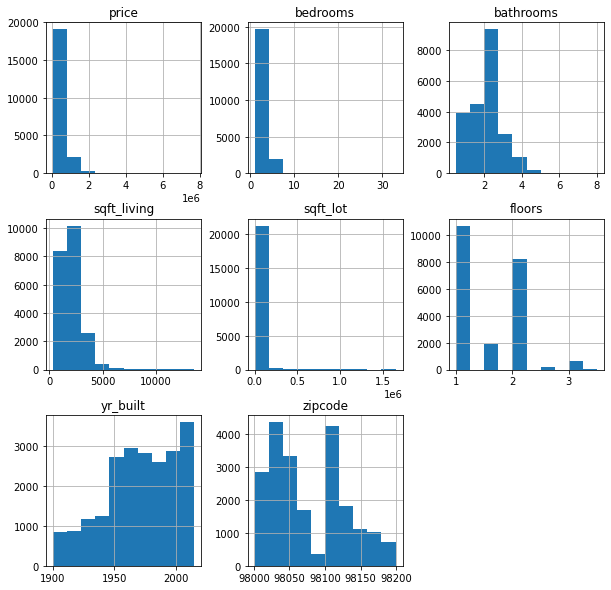

In [4]:
# Exploratory Visualizations
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
simple_housing.hist(ax = ax);

All of our features suffer from some level of skewness and will need to be transformed to facilitate modelling.

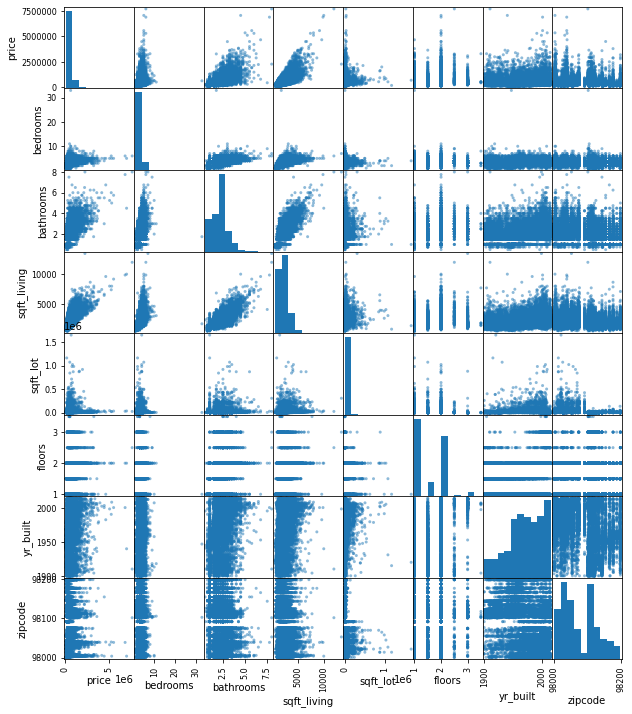

In [5]:
# scatter matrix
pd.plotting.scatter_matrix(simple_housing, figsize=(10,12));

# Data Preparation & Feature Engineering

Because we aim to maximize the value of our clients' investment, we do not believe home price is the most meaningful target variable. Certainly a higher sale price is appealing, but we must also consider the risk that comes with large individual investments. Expensive homes have a limited pool of buyers, even in a wealthy locale like King County. We will focus our analysis on the price per square foot of the properties in our data in order to allow our clients to make investment decisions that match their specific fund sizes and risk tolerances.

We elect to drop the one instance of a building grade 3, as this code signifies that the property fails to meet minimum building standards and could be unsafe..

In [6]:
# Add price per square foot feature
simple_housing['price_sqft'] = simple_housing['price'] / simple_housing['sqft_living']

# drop components of price_sqft, and poor-graded structure & confirm no NaNs
simple_housing = simple_housing.drop(columns=['price', 'sqft_living'])
simple_housing = simple_housing[simple_housing['grade']!='3 Poor']

# Map Missing values for waterfront to "no"
# There are only 146 waterfront properties in the dataset, less than 1% of known data.
simple_housing['waterfront'].fillna(value='NO', inplace=True)
simple_housing.isna().sum()

bedrooms      0
bathrooms     0
sqft_lot      0
floors        0
waterfront    0
condition     0
grade         0
yr_built      0
zipcode       0
price_sqft    0
dtype: int64

In [7]:
# Identify the single variable most correlated with price_sqft (in this data frame it's yr_built).
simple_housing.corr()

,bedrooms,bathrooms,sqft_lot,floors,yr_built,zipcode,price_sqft
bedrooms,1.000000,0.514413,0.032470,0.177866,0.155498,-0.154244,-0.205700
bathrooms,0.514413,1.000000,0.088375,0.502553,0.507103,-0.204893,-0.090123
sqft_lot,0.032470,0.088375,1.000000,-0.004817,0.052946,-0.129591,-0.034748
floors,0.177866,0.502553,-0.004817,1.000000,0.489163,-0.059588,0.004744
yr_built,0.155498,0.507103,0.052946,0.489163,1.000000,-0.347327,-0.289918
zipcode,-0.154244,-0.204893,-0.129591,-0.059588,-0.347327,1.000000,0.172880
price_sqft,-0.205700,-0.090123,-0.034748,0.004744,-0.289918,0.172880,1.000000


In [8]:
# Train/test split
X = simple_housing.drop(columns=['price_sqft'])
y = simple_housing['price_sqft']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40, test_size=0.33)

In [9]:
# Encode Categorical Variables in Test & Train data.

# Identify catgeorical values & create new df with only the categorical columns.
categoricals = ['condition', 'grade', 'waterfront', 'zipcode']
X_train_cats = X_train[categoricals]
X_test_cats = X_test[categoricals]

# OneHot encoding for categorical variables in Train data. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
X_train_cats_encoded = ohe.fit_transform(X_train_cats)
X_train_cats_df = pd.DataFrame(X_train_cats_encoded.todense(), columns=ohe.get_feature_names(categoricals))

# Drop original categorical columns, concatenate encoded columns.
X_train_data = X_train.drop(columns=categoricals)
X_train_encoded = pd.concat([X_train_data.reset_index(drop=True), X_train_cats_df.reset_index(drop=True)], axis=1)
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14469 entries, 0 to 14468
Data columns (total 88 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms             14469 non-null  int64  
 1   bathrooms            14469 non-null  float64
 2   sqft_lot             14469 non-null  int64  
 3   floors               14469 non-null  float64
 4   yr_built             14469 non-null  int64  
 5   condition_Fair       14469 non-null  float64
 6   condition_Good       14469 non-null  float64
 7   condition_Poor       14469 non-null  float64
 8   condition_Very Good  14469 non-null  float64
 9   grade_11 Excellent   14469 non-null  float64
 10  grade_12 Luxury      14469 non-null  float64
 11  grade_13 Mansion     14469 non-null  float64
 12  grade_4 Low          14469 non-null  float64
 13  grade_5 Fair         14469 non-null  float64
 14  grade_6 Low Average  14469 non-null  float64
 15  grade_7 Average      14469 non-null 

In [10]:
# OneHot encoding for categorical variables in Test data.
ohe = OneHotEncoder(drop='first')
X_test_cats_encoded = ohe.fit_transform(X_test_cats)
X_test_cats_df = pd.DataFrame(X_test_cats_encoded.todense(), columns=ohe.get_feature_names(categoricals))
X_test_data = X_test.drop(columns=categoricals)
X_test_encoded = pd.concat([X_test_data.reset_index(drop=True), X_test_cats_df.reset_index(drop=True)], axis=1)
X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7127 entries, 0 to 7126
Data columns (total 88 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms             7127 non-null   int64  
 1   bathrooms            7127 non-null   float64
 2   sqft_lot             7127 non-null   int64  
 3   floors               7127 non-null   float64
 4   yr_built             7127 non-null   int64  
 5   condition_Fair       7127 non-null   float64
 6   condition_Good       7127 non-null   float64
 7   condition_Poor       7127 non-null   float64
 8   condition_Very Good  7127 non-null   float64
 9   grade_11 Excellent   7127 non-null   float64
 10  grade_12 Luxury      7127 non-null   float64
 11  grade_13 Mansion     7127 non-null   float64
 12  grade_4 Low          7127 non-null   float64
 13  grade_5 Fair         7127 non-null   float64
 14  grade_6 Low Average  7127 non-null   float64
 15  grade_7 Average      7127 non-null   f

### Data Transformation
We identified previously that our continuous variables all suffer from some level of skew, which we attempted to address with a log-transformation. The results of the transformation are visible in the below scatter matrix--bathrooms, bedrooms and sqft_lot are noticeably improved, while year built and floors remain skewed.  

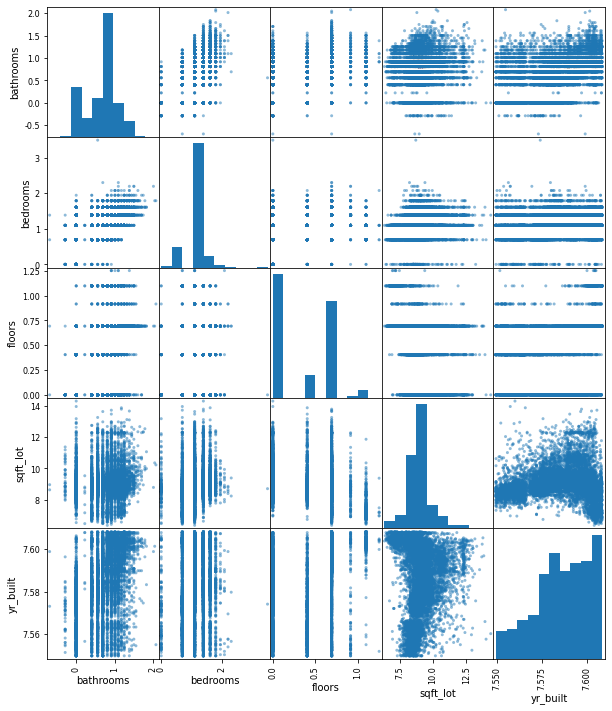

In [11]:
# log-transform non-normal features of Train Data
non_normal = ['bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'yr_built']
train_preds_log = pd.DataFrame([])
train_preds_log[non_normal] = np.log(X_train_encoded[non_normal])
train_preds_log = pd.concat([train_preds_log.reset_index(drop=True), X_train_encoded.iloc[:,6:].reset_index(drop=True)], axis=1)

# log-transform non-normal features of Test Data
test_preds_log = pd.DataFrame([])
test_preds_log[non_normal] = np.log(X_test_encoded[non_normal])
test_preds_log = pd.concat([test_preds_log.reset_index(drop=True), X_test_encoded.iloc[:,6:].reset_index(drop=True)], axis=1)

# Visualize Impact of Logged Train Preds
pd.plotting.scatter_matrix(train_preds_log[non_normal], figsize=(10,12));

To facilitate easier comparison of our model coefficients we applied a standard scalar to our train and test data below.

In [12]:
# Perform scaling of our training data utilizing StandardScaler
ss = StandardScaler()

X_train_scaled = ss.fit_transform(train_preds_log)
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=train_preds_log.index, columns=train_preds_log.columns)

# Perform scaling of our test data utilizing StandardScaler
X_test_scaled = ss.fit_transform(test_preds_log)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=test_preds_log.index, columns=test_preds_log.columns)

# Modelling

Our modelling efforts included a dummy regressor model, a simple linear regression model, and two multiple linear regression models. The models are presented in order from simplest to most complex to demonstrate our iterative process.

### Dummy Regressor

We begin modelling efforts by creating a dummy regressor model to provide a baseline. 

In [13]:
# Code Credit to geeksforgeeks.org. https://www.geeksforgeeks.org/dummy-regressor/
lm = LinearRegression().fit(X_train_scaled, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train_scaled, y_train) 
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train_scaled, y_train)
y_predict = lm.predict(X_test_scaled)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test_scaled)
y_predict_dummy_median = lm_dummy_median.predict(X_test_scaled)

In [14]:
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, y_predict_dummy_mean)))

print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, y_predict_dummy_median)))

print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))

Mean squared error (dummy): 12190.92
Median absolute error (dummy): 66.66
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.03


### First Simple Model

Among our initial set of features, the year in which the house was built was the most correlated variable with price per square foot. The negative correlation might mean that buyers in King county value older houses at a higher rate than new-builds. We began our analysis by modelling the log-scaled and standardized year in which the houses were constructed against the price per square foot. Unsurprisingly, the model is quite weak wtih an R<sup>2</sup> value of 0.012. We will move from here to a multiple linear regression model that considers all of the variables in our test data. 

In [15]:
# Add constant term/y-intercept to train data
X_train_const = sm.add_constant(X_train_scaled_df)
X_test_const = sm.add_constant(X_test_scaled_df)

In [16]:
# Reshape y_train to facilitate modeling against X_train
y_train=y_train.values.reshape(-1,1)
model = sm.OLS(endog=y_train, exog=X_train_const['yr_built']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              179.9
Date:                Fri, 24 Jun 2022   Prob (F-statistic):                    8.96e-41
Time:                        11:13:16   Log-Likelihood:                     -1.0228e+05
No. Observations:               14469   AIC:                                  2.046e+05
Df Residuals:                   14468   BIC:                                  2.046e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yr_built     -31.6906      2.363    -13.412      0.000     -36.322     -27.059
==============================================================================
Omnibus:                     2739.693   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5697.114
Skew:                           1.122   Prob(JB):                         0.00
Kurtosis:                       5.101   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### First Multiple Linear Regression Model

For our first multiple linear regression model, we elected to remove zip codes from the train/test data due to the large number of features created by one hot encoding the zips. We will explore their inclusion in subsequent models.

In [17]:
# Remove columns beginning with 'zip' from the train/test data and redefine our variables with 1, signifying the model.
cols = [c for c in X_train_const if c.lower()[:3] != 'zip']
X_train_const1 = X_train_const[cols]
X_test_const1 = X_test_const[cols]

In [18]:
# First Multiple Linear Regression Model
model = sm.OLS(endog=y_train, exog=X_train_const1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     382.8
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:13:16   Log-Likelihood:                -85692.
No. Observations:               14469   AIC:                         1.714e+05
Df Residuals:                   14450   BIC:                         1.716e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 264.0528      0.751    351.377      0.000     262.580     265.526
bathrooms              -9.2793      1.215     -7.638      0.000     -11.661      -6.898
bedrooms              -26.9938      0.921    -29.319      0.000     -28.798     -25.189
floors                  1.5796      1.005      1.572      0.116      -0.390       3.550
sqft_lot              -23.3826      0.849    -27.533      0.000     -25.047     -21.718
yr_built              -43.8181      1.004    -43.651      0.000     -45.786     -41.850
condition_Good          1.5848      0.824      1.923      0.055      -0.031       3.201
condition_Poor         -1.1635      0.757     -1.536      0.124      -2.648       0.321
condition_Very Good     4.6518      0.814      5.713      0.000       3.056       6.248
grade_11 Excellent      5.7935      0.870      6.656      0.000       4.087       7.500
grade_12 Luxury         7.6452      0.780      9.800      0.000       6.116       9.174
grade_13 Mansion        4.9851      0.756      6.590      0.000       3.502       6.468
grade_4 Low            -5.5903      0.772     -7.241      0.000      -7.103      -4.077
grade_5 Fair          -20.5830      0.871    -23.632      0.000     -22.290     -18.876
grade_6 Low Average   -53.6972      1.430    -37.558      0.000     -56.500     -50.895
grade_7 Average       -70.6397      1.929    -36.615      0.000     -74.421     -66.858
grade_8 Good          -45.3768      1.687    -26.894      0.000     -48.684     -42.070
grade_9 Better        -16.6758      1.300    -12.828      0.000     -19.224     -14.128
waterfront_YES         17.0153      0.759     22.405      0.000      15.527      18.504
==============================================================================
Omnibus:                     2411.678   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5646.702
Skew:                           0.954   Prob(JB):                         0.00
Kurtosis:                       5.393   Cond. No.                         6.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R<sup>2</sup> value is much improved over our simple model, but still quite low. We will likely need to add additional features in order to improve the model. From our original dataset, zipcode is an appealing proxy for several attributes of a home, i.e. school district, proximity to amenities, etc. We will include the effect of zip code on price_sqft in our next model.

##### Homoskedasticity

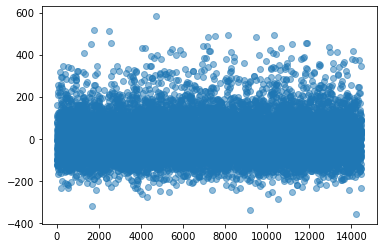

In [19]:
# Fit Linear Regression object on the train data and scatter plot residuals.

lr = LinearRegression()
lr.fit(X_train_const1, y_train)

y_hat = lr.predict(X_train_const1)
resid = y_train - y_hat

fig, ax=plt.subplots()
ax.scatter(x=range(y_hat.shape[0]), y=resid, alpha=0.5);

##### Normality of Errors
Creating a QQ plot and a histogram of the residuals revealed that although our transformations improved the normality of the data distribution, our train and test data contain outliers. Future models could explore removing the outliers in order to improve model accuracy.

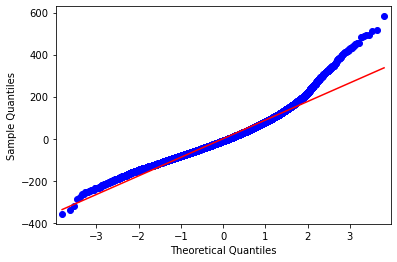

In [20]:
train_preds = lr.predict(X_train_const1)
test_preds = lr.predict(X_test_const1)

# Calculate Residuals
train_residuals = np.ndarray.flatten(y_train) - np.ndarray.flatten(train_preds)
test_residuals = y_test - np.ndarray.flatten(test_preds)

# QQ Plot -- Train
sm.qqplot(train_residuals, line='r');

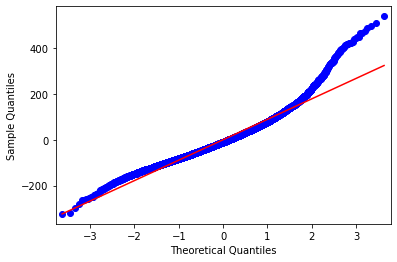

In [21]:
# QQ Plot -- Test
sm.qqplot(test_residuals, line='r');

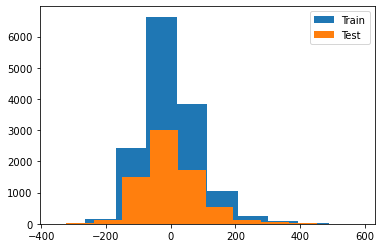

In [22]:
# Histogram of residuals
plt.hist(train_residuals, label='Train')
plt.hist(test_residuals, label='Test')
plt.legend()

plt.show()

##### Multicolinearity
Building grade 7 and grade 8 are above the general comfort level for VIF of 5. Future models could look to address this feature, although as categorical variables we cannot remove one or the other. 

In [23]:
# Test for multicolinearity among features with VIF score

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train_const1.values, i) for i in range(len(X_train_const1.columns))]
vif["features"] = X_train_const1.columns

vif.sort_values(by='VIF', ascending=False)

,VIF,features
15,6.590773,grade_7 Average
16,5.040943,grade_8 Good
14,3.619532,grade_6 Low Average
17,2.992392,grade_9 Better
1,2.613882,bathrooms
3,1.788617,floors
5,1.784326,yr_built
2,1.501039,bedrooms
13,1.343300,grade_5 Fair
9,1.341469,grade_11 Excellent


#### Model Validation

Our first model performed slightly worse on the test than train data, but not enough to merit concern. Train/Test root mean squared errors appear quite high at 90.33 / 91.23 per square foot.

In [24]:
# Fit linear regression object on train data
regressor = LinearRegression()
regressor.fit(X_train_const1, y_train)

# Calculate predicted values for train and test data.
y_pred_train = regressor.predict(X_train_const1)
y_pred_test = regressor.predict(X_test_const1)

# Calculate mean absolute and squared error and root mean squared error on TRAIN data
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)

print(f'Train mean absolute error: {train_mae:.2f}')
print(f'Train mean squared error: {train_mse:.2f}')
print(f'Train root mean squared error: {train_rmse:.2f}')

# Calculate mean absolute and squared error and root mean squared error on TEST data
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)

print(f'Test mean absolute error: {test_mae:.2f}')
print(f'Test mean squared error: {test_mse:.2f}')
print(f'Test root mean squared error: {test_rmse:.2f}')

Train mean absolute error: 68.10
Train mean squared error: 8160.26
Train root mean squared error: 90.33
Test mean absolute error: 68.26
Test mean squared error: 8322.33
Test root mean squared error: 91.23


### 2nd Linear Regression - Zip Codes

Including the zip code data has dramatically improved the R<sup>2</sup> value of our model--slightly more than doubling it from 0.323 to 0.665. It appears that zip codes generally have a significant impact on the price per square foot of the properties in the data set.

There are several large pvalues within the model, suggesting that number of floors, building grade 4, and certain zip codes may not have a stastically significant impact on the price per square foot of those properties. Given more time or resources we would look to investigate these features to better address their impact on the model.

In [25]:
# Rerun multiple linear regression, this time including zip codes
model = sm.OLS(endog=y_train, exog=X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     328.2
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:13:17   Log-Likelihood:                -80599.
No. Observations:               14469   AIC:                         1.614e+05
Df Residuals:                   14381   BIC:                         1.620e+05
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 264.0528      0.530    498.422      0.000     263.014     265.091
bathrooms             -17.1525      0.867    -19.786      0.000     -18.852     -15.453
bedrooms              -20.8147      0.666    -31.265      0.000     -22.120     -19.510
floors                 -1.4664      0.742     -1.977      0.048      -2.921      -0.012
sqft_lot                4.9805      0.776      6.414      0.000       3.459       6.503
yr_built               -1.8620      0.899     -2.071      0.038      -3.625      -0.100
condition_Good          1.7035      0.601      2.837      0.005       0.526       2.881
condition_Poor         -2.4401      0.537     -4.547      0.000      -3.492      -1.388
condition_Very Good     5.4053      0.585      9.244      0.000       4.259       6.551
grade_11 Excellent      3.0161      0.617      4.887      0.000       1.806       4.226
grade_12 Luxury         4.1330      0.555      7.450      0.000       3.046       5.220
grade_13 Mansion        3.1869      0.536      5.946      0.000       2.136       4.238
grade_4 Low             0.4507      0.550      0.819      0.413      -0.627       1.529
grade_5 Fair           -4.1713      0.641     -6.513      0.000      -5.427      -2.916
grade_6 Low Average   -14.4516      1.091    -13.242      0.000     -16.591     -12.312
grade_7 Average       -24.1215      1.462    -16.498      0.000     -26.987     -21.256
grade_8 Good          -17.4374      1.240    -14.065      0.000     -19.867     -15.007
grade_9 Better         -6.3458      0.931     -6.820      0.000      -8.170      -4.522
waterfront_YES         19.6322      0.544     36.068      0.000      18.565      20.699
zipcode_98002          -0.5424      0.660     -0.822      0.411      -1.836       0.752
zipcode_98003           0.5391      0.695      0.776      0.438      -0.822       1.901
zipcode_98004          37.0110      0.727     50.929      0.000      35.587      38.435
zipcode_98005          13.8544      0.645     21.490      0.000      12.591      15.118
zipcode_98006          22.3629      0.829     26.979      0.000      20.738      23.988
zipcode_98007          11.0518      0.619     17.856      0.000       9.839      12.265
zipcode_98008          16.7416      0.710     23.578      0.000      15.350      18.133
zipcode_98010           2.8306      0.600      4.720      0.000       1.655       4.006
zipcode_98011           7.6876      0.652     11.797      0.000       6.410       8.965
zipcode_98014           3.4490      0.621      5.556      0.000       2.232       4.666
zipcode_98019           5.1864      0.652      7.951      0.000       3.908       6.465
zipcode_98022           1.3658      0.678      2.014      0.044       0.037       2.695
zipcode_98023          -0.7351      0.816     -0.900      0.368      -2.335       0.865
zip

#### Checking Model Assumptions

##### Homoskedasticity

A scatter plot of our model's residuals did not reveal any concerns with heteroskedasticity. There is not a clearly observable cone pattern that would make us think our data's errors are not evenly distributed.

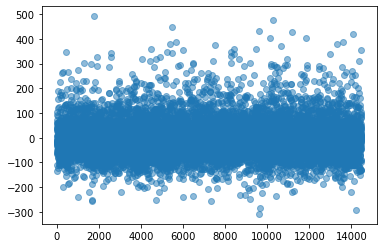

In [26]:
# Fit Linear Regression object on the train data and scatter plot residuals.

lr = LinearRegression()
lr.fit(X_train_const, y_train)

y_hat = lr.predict(X_train_const)
resid = y_train - y_hat

fig, ax=plt.subplots()
ax.scatter(x=range(y_hat.shape[0]), y=resid, alpha=0.5);

##### Normality
Creating a QQ plot and a histogram of the residuals revealed that although our transformations improved the normality of the data distribution, our train and test data contain outliers. Future models could explore removing the outliers in order to improve model accuracy.

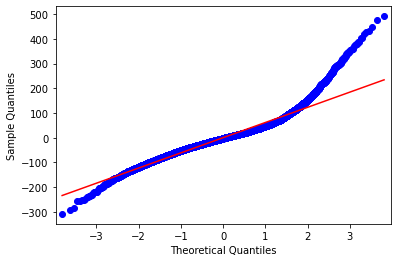

In [27]:
train_preds = lr.predict(X_train_const)
test_preds = lr.predict(X_test_const)

# Calculate Residuals
train_residuals = np.ndarray.flatten(y_train) - np.ndarray.flatten(train_preds)
test_residuals = y_test - np.ndarray.flatten(test_preds)

# QQ Plot -- Train
sm.qqplot(train_residuals, line='r');

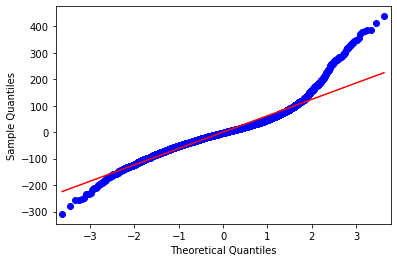

In [28]:
# QQ Plot -- Test
sm.qqplot(test_residuals, line='r');

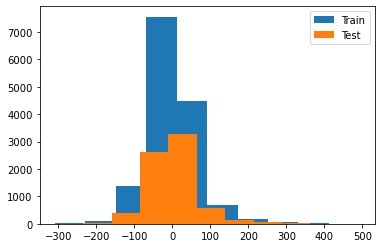

In [29]:
# Histogram of residuals
plt.hist(train_residuals, label='Train')
plt.hist(test_residuals, label='Test')
plt.legend()

plt.show()

##### Multicolinearity
Building grade 7 and grade 8 remain problematic, and their impacts were magnified slightly in this model. Given additional time and resources, we would explore whether removing these features would improve model accuracy. 

In [30]:
# Test for Multicolinearity

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train_const.values, i) for i in range(len(X_train_const.columns))]
vif["features"] = X_train_const.columns

vif.sort_values(by='VIF', ascending=False)

,VIF,features
15,7.616960,grade_7 Average
16,5.476234,grade_8 Good
14,4.243512,grade_6 Low Average
17,3.084952,grade_9 Better
60,2.924849,zipcode_98103
...,...,...
12,1.077895,grade_4 Low
18,1.055619,waterfront_YES
7,1.026018,condition_Poor
11,1.023622,grade_13 Mansion


### Final Model Validation / Evaluation

In this section, we will discuss the performance and validity of our model, as well as the impact of certain features with the largest correlation coefficients. Note that some of the data referenced here appears below the written work, specifically the train/test comparisons of R<sup>2</sup> and RMSE.

With an R<sup>2</sup> score of 0.665, we can say that our model captures ~66% of the variance in price per square foot that our features can collectively explain. As noted above, there are small issues with multicolinearity that could be addressed in future iterations to improve the model. Encouragingly, our model performed very similarly on our test and train data, with no significant difference in either  R<sup>2</sup> or RMSE scores. This suggests that the model is functioning with relatively low bias and low variance. While the absolute R<sup>2</sup> score leaves much to be desired, our model does not seem to be under or overfitted. Additional features could be added to improve R<sup>2</sup>.

The root mean squared error score of 63.94 on the test data signifies that our model will generally have error of \\$63.94 per square foot of a property. Compared with the mean price per square foot in the test data of $264.29, a \\$63.94 error is significant, particularly when properties can be several thousand square feet. However, the RMSE is well within one standard deviation of the price per square foot in the test data, which measured \\$110.42. Comparisons to the train data were similar, with a root mean squared error score of 63.53, compared to mean price per square foot of \\$264.05 and a standard deviation of \\$109.78.

Our 12 strongest coefficients (ranging from 37.01 for zip 98004 to 24.39 for zip 98119) are all related to the zip codes in which the properties are located, suggesting that the attributes of a zip code have significant impact on property value. Following these appealing zip codes, building grade 7, which was labeled 'average' carried the next largest impact on price per square foot, with a negative coefficient of -24.12. Perhaps unsurprisingly, the waterfront feature had a coefficient of 19.63, suggesting that a waterfront property can expect an increase of \\$19.63 per square foot.

Based on our evaluation of model performance, we believe its use is warranted provided further effort goes into reducing outliers in the data.

In [31]:
print('R-squared score on train data: ' ,lr.score(X_train_const, y_train).round(4))
print('R-squared score on test data: ' , lr.score(X_test_const, y_test).round(4))

R-squared score on train data:  0.6651
R-squared score on test data:  0.6646


In [32]:
# Fit linear regression object on train data
regressor = LinearRegression()
regressor.fit(X_train_const, y_train)

# Calculate predicted values for train and test data.
y_pred_train = regressor.predict(X_train_const)
y_pred_test = regressor.predict(X_test_const)

# Calculate mean absolute and squared error and root mean squared error on TRAIN data
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)

print(f'Train mean absolute error: {train_mae:.2f}')
print(f'Train mean squared error: {train_mse:.2f}')
print(f'Train root mean squared error: {train_rmse:.2f}')

# Calculate mean absolute and squared error and root mean squared error on TEST data
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)

print(f'Test mean absolute error: {test_mae:.2f}')
print(f'Test mean squared error: {test_mse:.2f}')
print(f'Test root mean squared error: {test_rmse:.2f}')

Train mean absolute error: 44.54
Train mean squared error: 4036.24
Train root mean squared error: 63.53
Test mean absolute error: 44.51
Test mean squared error: 4088.48
Test root mean squared error: 63.94


In [33]:
# Calculate price_sqft mean and standard deviation in train/test data.
print('Mean price per square foot in training data: ', y_train.mean().round(2))
print('Mean price per square foot in test data: ', y_test.mean().round(2))

print('Standard deviation of price per square foot in training data: ', y_train.std().round(2))
print('Standard deviation of price per square foot in test data: ', y_test.std().round(2))

Mean price per square foot in training data:  264.05
Mean price per square foot in test data:  264.29
Standard deviation of price per square foot in training data:  109.78
Standard deviation of price per square foot in test data:  110.42


## Visualizations

The following visualizations were created to aid in the presentation and highlight meaningful coefficients from our model.

In [34]:
# Create dataframe of correlation coefficients from Final Model.
regressor = LinearRegression()
regressor.fit(X_train_const, y_train)
model_coefficients = regressor.coef_.reshape(-1,1)
feature_names = X_train_const.columns
coefficients_df = pd.DataFrame(data = model_coefficients, index = feature_names, columns = ['Coefficient value'])
coefficients_df2 = coefficients_df.sort_values(by='Coefficient value', ascending=False).head(25)

In [35]:
waterfront_coef = [19.63220]

In [36]:
# Create dataframe of mean data for zip codes with the eight highest correlation coefficients
simple_means = simple_housing.groupby('zipcode').mean()
target_codes = [98004, 98103, 98115, 98117, 98033, 98105, 98040, 98199] 
viz_zips = simple_means.loc[target_codes].reset_index()
viz_zips

,zipcode,bedrooms,bathrooms,sqft_lot,floors,yr_built,price_sqft
0,98004,3.854890,2.527603,13104.220820,1.432177,1971.470032,475.609615
1,98103,3.059801,1.934801,3482.445183,1.827243,1953.089701,369.882756
2,98115,3.204117,1.866638,5444.144082,1.420240,1948.926244,354.157213
3,98117,3.019892,1.812839,4636.388788,1.457505,1948.271248,363.546251
4,98033,3.560185,2.333912,10493.812500,1.496528,1978.405093,343.241531
5,98105,3.580786,2.159389,5121.165939,1.591703,1940.406114,405.283209
6,98040,4.028369,2.716312,13704.464539,1.505319,1971.471631,387.479406
7,98199,3.211356,2.167981,5436.283912,1.468454,1956.526814,376.659850


#### Mean Price per Square Foot by Zip Code for Zips with Highest Impact on Price per Square Foot

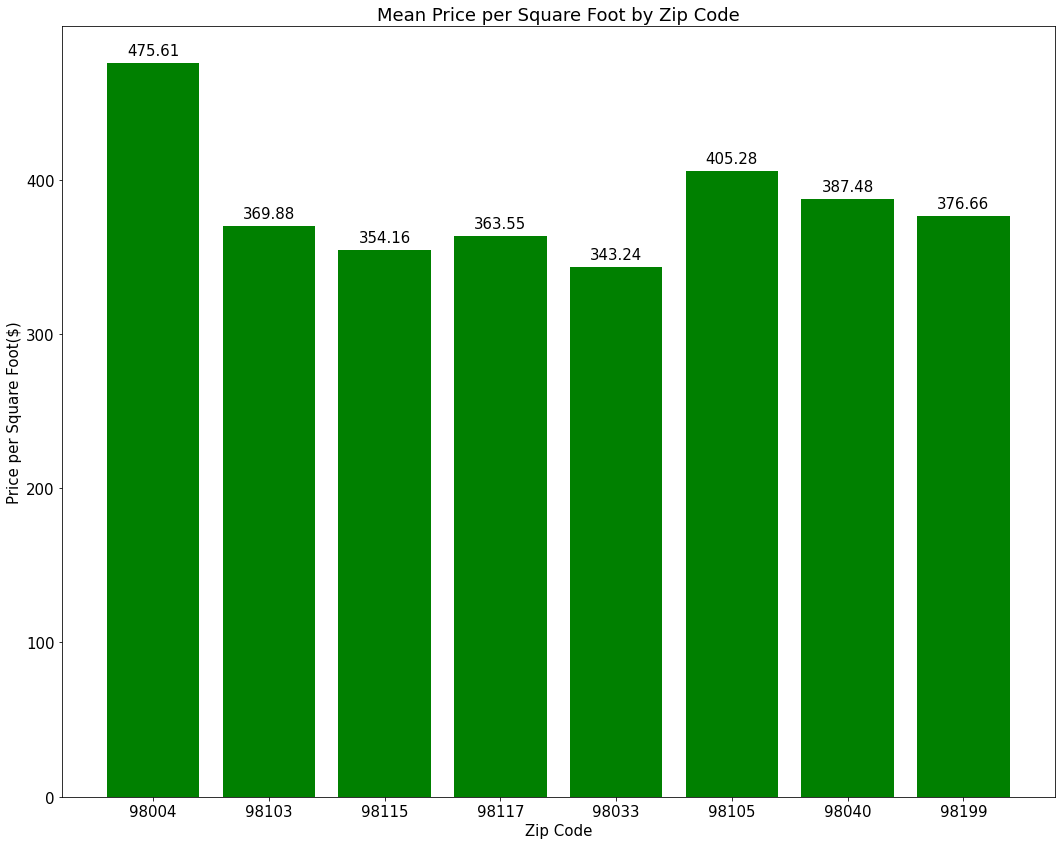

In [37]:
# Create x and y axis label data
zip_labels = list(viz_zips['zipcode'].apply(str))
price_labels = list(viz_zips['price_sqft'].round(2))

# Plot mean price/sqft for zip codes in zip labels
plt.rcParams.update({'font.size': 15});
x = np.arange(len(zip_labels))
width = 0.35 

fig, ax = plt.subplots(figsize=(15,12))
ax.set_ylabel('Price per Square Foot($)')
ax.set_xlabel('Zip Code')
ax.set_title('Mean Price per Square Foot by Zip Code')
ax.set_xticks(x)
ax.set_xticklabels(zip_labels)

pps = ax.bar(zip_labels, price_labels, color='green')
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 5), 
      textcoords="offset points",  
      ha='center', va='bottom')
plt.tight_layout()

plt.savefig('./images/mean_psft_zip', facecolor='white', dpi=500)

#### Correlation Coefficients for Zip Codes with Highest Impact on Price per Square Foot

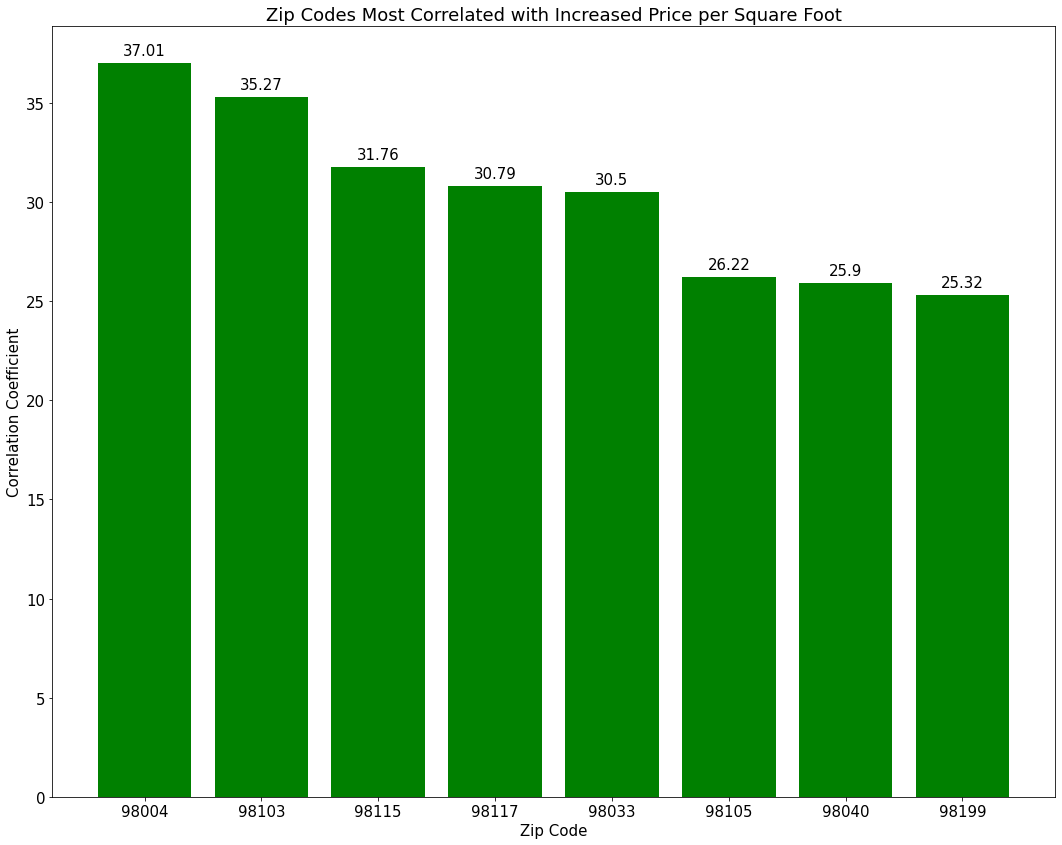

In [38]:
# Create x and y axis label data
zip_labels = list(viz_zips['zipcode'].apply(str))
viz_coef = coefficients_df2['Coefficient value'].head(8).round(2).to_list()


plt.rcParams.update({'font.size': 15});
x = np.arange(len(zip_labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(15,12))

ax.set_ylabel('Correlation Coefficient')
ax.set_xlabel('Zip Code')
ax.set_title('Zip Codes Most Correlated with Increased Price per Square Foot')
ax.set_xticks(x)
ax.set_xticklabels(zip_labels)

pps = ax.bar(zip_labels, viz_coef, color='green')
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 5), # 3 points vertical offset
      textcoords="offset points",  
      ha='center', va='bottom')
plt.tight_layout()
plt.savefig('./images/zip_coefs', facecolor='white', dpi=500)

#### Correlation Coefficients for Building Grades

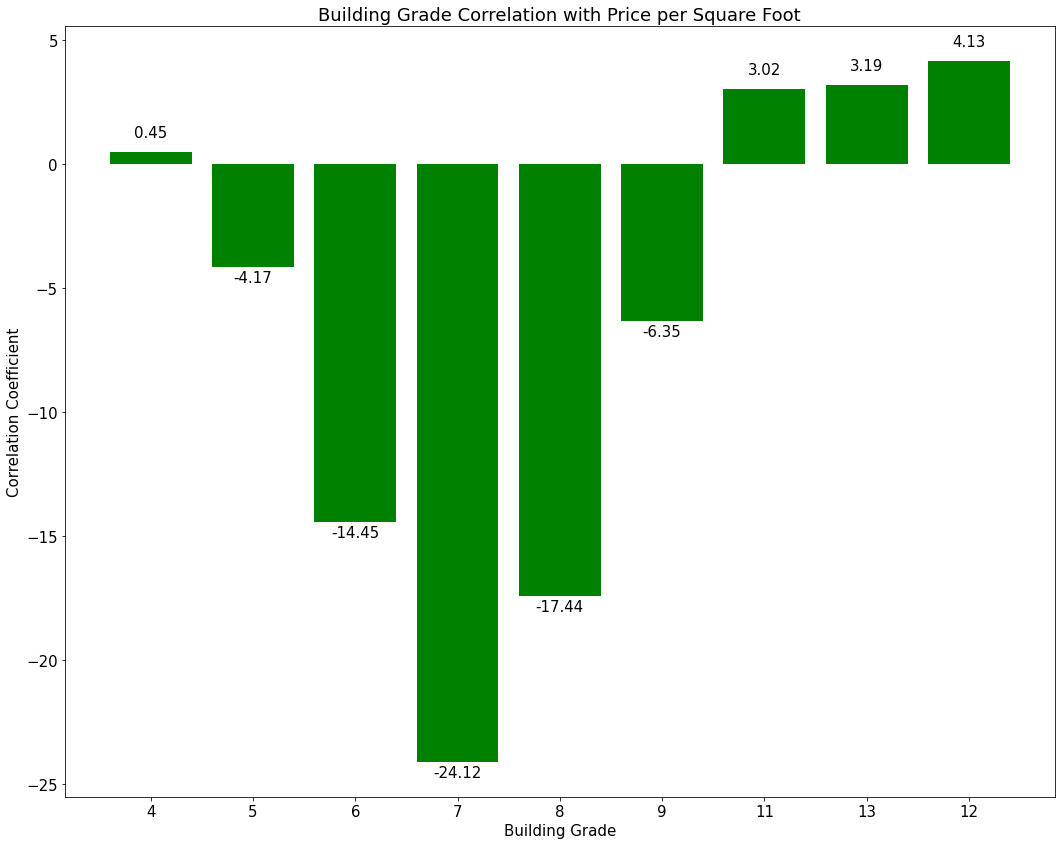

In [39]:
# Create x and y axis label data

grade_coefs =  {'4': 0.450,
                '5': -4.17,
                '6': -14.45,
                '7': -24.12,
                '8': -17.44,
                '9': -6.35,
                '11': 3.02,
                '13': 3.19,
                '12': 4.13}

plt.rcParams.update({'font.size': 15});
x = np.arange(len(grade_coefs.keys())) 
width = 0.35 

fig, ax = plt.subplots(figsize=(15,12))

ax.set_ylabel('Correlation Coefficient')
ax.set_xlabel('Building Grade')
ax.set_title('Building Grade Correlation with Price per Square Foot')
ax.set_xticks(x)
ax.set_xticklabels(grade_coefs.keys())

mask1 = y < 0
mask2 = y >= 0
pps = ax.bar(grade_coefs.keys(), grade_coefs.values(), color='green')

for p in pps:
    height = p.get_height()
    if height > 0:
        ax.annotate('{}'.format(height), xy=(p.get_x() + p.get_width() / 2, height), xytext=(0, 15),
        textcoords="offset points", ha='center')  
        
    else:
        ax.annotate('{}'.format(height), xy=(p.get_x() + p.get_width() / 2, height), xytext=(0, -15),
        textcoords="offset points", ha='center')  # 3 points vertical offset
plt.tight_layout()
plt.savefig('./images/grade_coefs', dpi=500)

#### Final Model Image for README

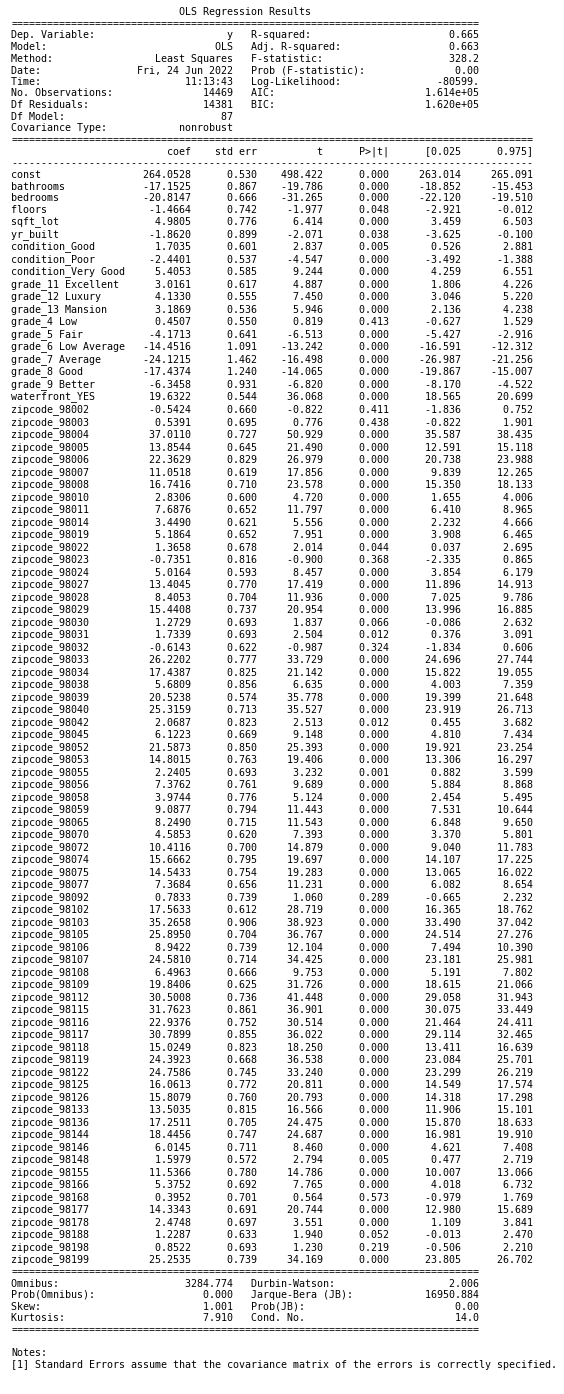

In [40]:
#Code credit to sascha @ stackoverflow. https://stackoverflow.com/questions/46664082/python-how-to-save-statsmodels-results-as-image-file

plt.rc('figure', figsize=(7, 7), facecolor='white')
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')

plt.tight_layout()
plt.savefig('./images/model', bbox_inches = 'tight', facecolor='white', dpi=500)

In [41]:
coefficients_df.sort_values(by = 'Coefficient value', ascending=False).head(25)

,Coefficient value
zipcode_98004,37.011021
zipcode_98103,35.265758
zipcode_98115,31.762319
zipcode_98117,30.789862
zipcode_98112,30.500815
zipcode_98033,26.220226
zipcode_98105,25.895017
zipcode_98040,25.315867
zipcode_98199,25.253516
zipcode_98122,24.758625


# Conclusions

Our final model performed similarly on the train and test data, and with an R<sup>2</sup> score of 0.66, it is approaching a usable model. Further iteration is needed to address small issues with multicolinearity and address the presence of outliers in both the train and test data. We identified the following features and their correlation coefficients that had the strongest positive or negative impacts on price per square foot in King County:

* __Zip Codes 98004 (37.01), 98103 (35.27), 98115 (31.76), 98117 (30.79), 98112 (30.50),  98033 (26.22), 98105 (25.90), and 98040 (25.32).__ Considering that school districts, traffic patterns, proximity to amenities, crime, etc. all vary with zip code, it is reasonable to expect that the difference between our baseline zip code of 98001 and certain others will have a significant impact on property value. The baseline zip of 98001 is primarily associated with Auburn, WA, an inland suburb situated about halfway between Seattle and Tacoma. We chose this as a baseline because it is close enough to have access to Seattle-area amenities but far enough away to be more reasonably priced than some of the urban areas.

* __Building Grades 7 (-24.12) and 8 (-17.44).__ While building grades are quite subjective, these two grades most closely define average quality of construction methods and materials. Each has a negative impact on price per square foot, with grade 7 and 8 having correlation coefficients of -24.12 and -17.44, respectively. One might assume that given the climate, proximity to salt water and steep hills present in King County, buyers prize quality materials and construction methods that will last in a hostile environment.

* __Bedrooms (-20.82).__ All else being equal, each additional bedroom had a negative effect on price per square foot of \\$20.81. At first blush this is surprising, but square footage that is used for bedrooms is not being utilized for spaces that are more closely associated with home value such as kitchen and entertaining space. Further analysis would be needed to more fully explain the negative correlation of bedrooms and price per square foot in King County.

* __Waterfront Property (19.63).__ Perhaps the least surprising finding in the study, a property's designation as waterfront had a positive impact on price per square foot. 


# Recommendations

Based on our findings, we recommend that:
1. Focus property searches within the zip codes with most impact on price per square foot.
2. Avoid properties built with average materials and techniques. 
3. Be thoughtful about the number of bedrooms in target properties. Unless you have requirements for a high number of bedrooms, it would be best to avoid properties that use space this way.
4. To the extent waterfront property is available and priced appealingly, it should be the first stop for investors in King County.